## Hamiltonian Monte Carlo

Functions:
- Normal: returns the gaussian PDF with given point, mean and variance
- neg_log_prob: returns the neg log of the gaussian
- func: unknown function to maximize
- leapfrog_step: returns the updated parameters q1, p1
- metropolis_acceptance: calculates the ratio and returns True if the trajectory was acepted
- HMC: Produces an array of samples, of trajectories and a boolean array if the traj is accepted or not

In [169]:
import numpy as np
import random
import scipy.stats as st
import scipy.integrate as integ
import matplotlib.pyplot as plt
from tqdm import tqdm

def normal(x,mu,sigma):
    numerator = np.exp(-1*((x-mu)**2)/(2*sigma**2))
    denominator = sigma * np.sqrt(2*np.pi)
    return numerator/denominator

def neg_log_prob(x,mu,sigma):
    return -1*np.log(normal(x=x,mu=mu,sigma=sigma))

def func(x):
    return 0.2*normal(x, 0, 0.5) + 0.8*normal(x, 4, 0.5)

def leapfrog_step(q1, p1, step_size, dVdQ):
    p1 -= step_size*dVdQ/2 # as potential energy increases, kinetic energy decreases, half-step
    q1 += step_size*p1 # position increases as function of momentum 
    p1 -= step_size*dVdQ/2 # second half-step "leapfrog" update to momentum 
    return q1, p1

def metropolis_acceptance(q0, p0, q1, p1):
    q0_nlp = func(q0)
    q1_nlp = func(q1)

    p0_nlp = normal(x=p0,mu=0,sigma=1)
    p1_nlp = normal(x=p1,mu=0,sigma=1)

    target = q1_nlp/q0_nlp # P(q1)/P(q0)
    adjustment = p1_nlp/p0_nlp # P(p1)/P(p0)
    acceptance = target*adjustment
    
    event = random.uniform(0,1)
    return event <= acceptance

def HMC(path_len=1,step_size=0.1,initial_position=0.1, epsilon = 0.01, epochs=20_000):
    # setup
    steps = int(path_len/step_size) # path_len and step_size are tricky parameters to tune...
    momentum_dist = st.norm(0, 1)
    samples = [initial_position]
    trajectories = []
    success = [] 
    # generate samples
    for e in tqdm(range(epochs)):
        q0 = np.copy(samples[-1])
        q1 = np.copy(q0)
        p0 = momentum_dist.rvs()        
        p1 = np.copy(p0) 
        traj = [[q0, p0]]
        dVdQ = (-1*np.log(func(q0 + epsilon)) + np.log(func(q0)))/epsilon
        
        # leapfrog integration 
        for s in range(steps): 
            q1, p1 = leapfrog_step(q1, p1, step_size, dVdQ)
            traj.append(np.array([q1, p1]))  
        
        #flip momentum for reversibility 
        p1 = -1*p1     
        trajectories.append(traj)
        
        #metropolis acceptance
        accepted = metropolis_acceptance(q0, p0, q1, p1)
        
        #Decide acceptance or refusal
        if accepted:
            samples.append(q1)
            success.append(True)
        else:
            samples.append(q0)
            success.append(False)
    
    return np.array(samples[1:]), np.array(trajectories), np.array(success)

### Testing
Run HMC and plots histogram of ALL THE SAMPLED POINTS. Quindi se sei al punto 3 e generi 5 triettorie tutte rifiutate comunque il punto 3 compare 5 volte nella statistica dei trials, é giusto?

100%|██████████| 20000/20000 [00:02<00:00, 7903.64it/s]


Rate of accepted trajectories: 7025/20000 = 0.35125


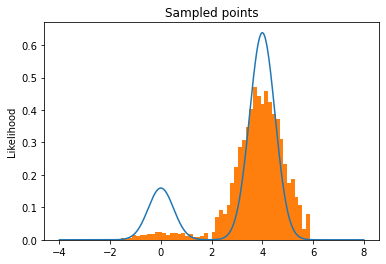

In [170]:
epochs = 20000
path_len = .8
step_size = 0.1
epsilon = 0.01

trial, trajectories, success= HMC(path_len=path_len,step_size=step_size, epsilon = epsilon, epochs = epochs)

trial = np.array(trial)
lines = np.linspace(-4,8,10_000)
normal_curve = [func(l) for l in lines]

accepted = np.sum(success)
print('Rate of accepted trajectories: {}/{} = {}'.format(accepted, epochs, accepted/epochs))
plt.plot(lines,normal_curve)
plt.hist(trial,density=True,bins=50)
plt.title('Sampled points')
plt.ylabel('Likelihood')
plt.show()    

We plot only the points obtained from an accepted trajectories (so there is no over counting)

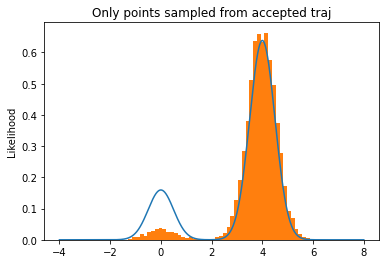

In [171]:
trial_accepted = trial[success == True]
lines = np.linspace(-4,8,10_000)
normal_curve = [func(l) for l in lines]

plt.plot(lines,normal_curve)
plt.hist(trial_accepted,density=True,bins=50)
plt.title('Only points sampled from accepted traj')
plt.ylabel('Likelihood')
plt.show()   

Last 100 sampled points

(array([ 3., 18.,  8., 10., 22.,  6.,  8.,  4., 16.,  5.]),
 array([3.2681641 , 3.43712391, 3.60608373, 3.77504354, 3.94400335,
        4.11296316, 4.28192298, 4.45088279, 4.6198426 , 4.78880241,
        4.95776223]),
 <BarContainer object of 10 artists>)

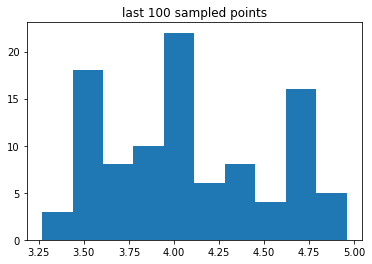

In [172]:
fig = plt.figure()
plt.title('last 100 sampled points')
plt.hist(trial[len(trial)-100:])

### Plotting
We plot the likelihood over the phase space: (q, p) to visualize the first and last trajectories.

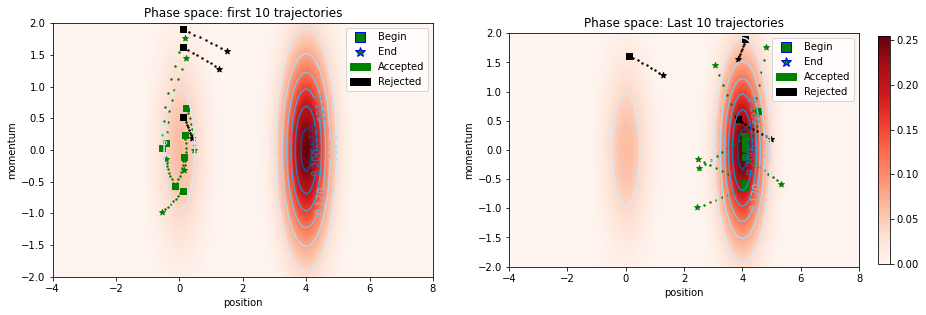

In [178]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

how_many_traj = 10


x = np.linspace(-4, 8, 100)
y = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(x, y)
Z1 = func(X)
Z2 = normal(Y, 0, 1)
Z = Z1*Z2

fig, axes = plt.subplots(1, 2, figsize = (15, 9))
ax1 = axes[0]
ax2 = axes[1]

#------------ FIRST PLOT ----------------------#
ax1.set_xlabel('position')
ax1.set_ylabel('momentum')
CS = ax1.contour(X, Y, Z, cmap = 'Blues')
ax1.clabel(CS, inline=True, fontsize=10)
im = ax1.imshow(Z, cmap = 'Reds', extent = [-4, 8, -2, 2], aspect = 2)
ax1.set_title('Phase space: first {} trajectories'.format(how_many_traj))

for i in range(how_many_traj):
    if np.any(trajectories[i,:, 1]<-2):
        continue
    if success[i] == True:
        c = 'Green'
    else:
        c = 'Black'
    ax1.scatter(trajectories[i, :,0], trajectories[i, :,1], s = 2, color = c)
    begin = ax1.scatter(trajectories[i, 0 ,0], trajectories[i, 0,1], marker = 's', color = c)
    end = ax1.scatter(trajectories[i, -1,0], trajectories[i, -1,1], marker = '*', color = c)

legend_elements = [
                   Line2D([0], [0], marker='s', lw = 0, color='blue', label='Begin',
                          markerfacecolor='g', markersize=10),
                    Line2D([0], [0], marker='*', lw = 0, color='blue', label='End',
                          markerfacecolor='g', markersize=10),
                   Patch(facecolor='g', edgecolor='g',
                         label='Accepted'),
                    Patch(facecolor='black', edgecolor='black',
                         label='Rejected')]
ax1.legend(handles=legend_elements)


#------------ SECOND PLOT ----------------------#

ax2.set_xlabel('position')
ax2.set_ylabel('momentum')
CS = ax2.contour(X, Y, Z, cmap = 'Blues')
ax2.clabel(CS, inline=True, fontsize=10)
im = ax2.imshow(Z, cmap = 'Reds', extent = [-4, 8, -2, 2], aspect = 2)
ax2.set_title('Phase space: Last {} trajectories'.format(how_many_traj))

for i in reversed(range(how_many_traj)):
    if np.any(trajectories[i,:, 1]<-2):
        continue
    if success[i] == True:
        c = 'Green'
    else:
        c = 'Black'
    ax2.scatter(trajectories[-i, :,0], trajectories[i, :,1], s = 2, color = c)
    begin = ax2.scatter(trajectories[-i, 0 ,0], trajectories[i, 0,1], marker = 's', color = c)
    end = ax2.scatter(trajectories[-i, -1,0], trajectories[i, -1,1], marker = '*', color = c)

legend_elements = [
                   Line2D([0], [0], marker='s', lw = 0, color='blue', label='Begin',
                          markerfacecolor='g', markersize=10),
                    Line2D([0], [0], marker='*', lw = 0, color='blue', label='End',
                          markerfacecolor='g', markersize=10),
                   Patch(facecolor='g', edgecolor='g',
                         label='Accepted'),
                    Patch(facecolor='black', edgecolor='black',
                         label='Rejected')]
ax2.legend(handles=legend_elements)

plt.colorbar(im, fraction=0.03)

## 2D